In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

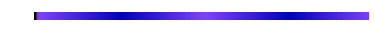

In [403]:
def palette():
    pal = np.zeros(128*3, np.uint8)
    pal[0:3] = 0
    ah = 0
    bl = 2
    for i in range(3, 128*3, 3):
        pal[i] = 0x20 - (ah >> 1)
        pal[i+1] = 0x10 - (ah >> 2)
        pal[i+2] = 0x3f - (ah >> 2)
        ah += bl
        ah = np.uint8(ah)
        if (ah > 0x40):
            bl = -bl
            ah += 2*bl
    return pal

pal = 4*palette().reshape((-1, 3))
p = 4*palette().reshape((1, -1, 3))
plt.imshow(np.vstack([p, p, p]))
plt.axis('off')
plt.show()

In [369]:
0x1f38 - 0x1e80

184

In [68]:
#map(hex, (127*np.sin(2*np.pi * np.arange(184) / 184)).astype(np.int8))

In [337]:
sintbl = np.frombuffer(open("WOWUNC.EXE").read()[0x1e80:0x2280], np.int8)

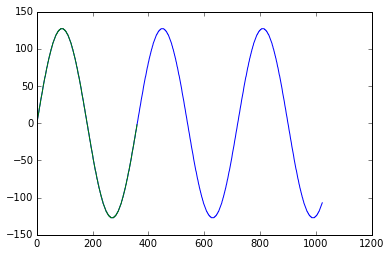

In [84]:
plt.plot(sintbl)
plt.plot(np.round(127*np.sin(2*np.pi * np.arange(360) / 360)))

In [88]:
np.round(127*np.sin(2*np.pi * np.arange(360) / 360)).astype(np.int8) - sintbl[:360]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [75]:
imgs = np.frombuffer(open("WOWUNC.EXE").read()[0x2280:0x8040], np.uint8).reshape((-1, 80))

60

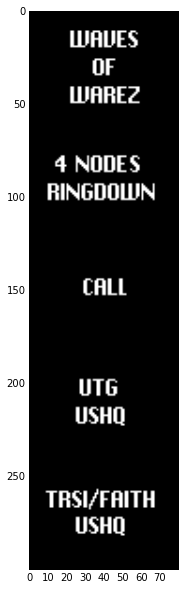

In [113]:
plt.figure(figsize=(4,10))
plt.imshow(imgs, 'gray')
imgs.shape[0] / 5

In [338]:
randstate = np.zeros(1, np.uint16) + 0x57fe
def wowrand():
    randstate[0] = randstate[0] * 0x13a7 + 1
    return randstate[0]

# the plasma is apparently 80x60

tbl_622b = np.zeros(60, np.int8)  # so these are the row offsets
angle_6383, angle_6385 = 0, 0
rand_638b = 1
tbl_6267 = np.zeros(60, np.int8)  # screen row buffer?

def update_rows():   # code 02E2..0343
    global angle_6383, angle_6385
    tbl_622b[:-1] = tbl_622b[1:]
    tbl_622b[-1] = sintbl[angle_6383] >> 1
    angle_6383 += rand_638b
    angle_6383 %= 360
    
    # now we copy 10 + sintbl[angle_6385]/2 + tbl_622b
    si = angle_6385
    for i in range(60):
        tbl_6267[i] = 0x10 + ((sintbl[si] >> 1) + tbl_622b[i] >> 3)
        si += 3
    angle_6385 += 4
    angle_6385 %= 360
    return tbl_6267

In [339]:
tbl_62a3 = np.zeros(112, np.int8)
angle_6387, angle_6389 = 0, 0
rand_638d = 7
tbl_6313 = np.zeros(112, np.int8)

def update_columns():  # code 0344..3A4
    global angle_6387, angle_6389
    tbl_62a3[:-1] = tbl_62a3[1:]
    tbl_62a3[-1] = sintbl[angle_6387] >> 1
    angle_6387 += rand_638d
    angle_6387 %= 360
    
    si = angle_6389
    for i in range(112):
        tbl_6313[i] = 0x20 + ((sintbl[si] >> 1) + tbl_62a3[i] >> 2)
        si += 2
    angle_6389 += 1
    angle_6389 %= 360
    return tbl_6313

In [340]:
tbl_638f = np.zeros((60, 255), np.uint8)
def expand_columns():
    for i in range(112):
        tbl_638f[:, i] = tbl_6313[i] + np.arange(60) + 1

In [398]:
def xor_text():
    for i in range(60):
        off = tbl_6267[i]
        tbl_638f[i, off:off+80] ^= imgs[i, :] & 0x0f

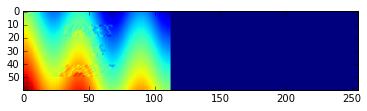

In [399]:
for i in range(10):
    update_rows()
    update_columns()
    expand_columns()
    rand_638d = 5 + (wowrand() & 3)
    rand_638b = 3 + (wowrand() & 7)
    xor_text()
plt.imshow(tbl_638f)

In [400]:
screen = np.zeros((60 * 80), np.int8)
def update_screen():
    bl = 0x3c
    dh = 0
    ptr = 0
    for i in range(60):
        al = tbl_6267[i]
        screen[ptr:ptr+80] = tbl_638f[dh, al:al+80]
        ptr += 80
        dh += 1
    return screen

(-0.5, 79.5, 59.5, -0.5)

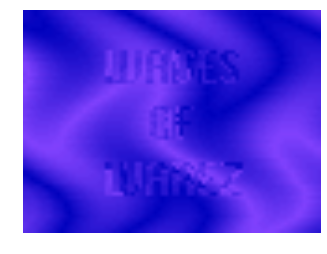

In [401]:
update_screen()
plt.imshow(pal[screen.reshape((60, 80)) & 0x7f])
plt.axis('off')

In [384]:
import cv2

In [402]:
while True:
    update_rows()
    update_columns()
    expand_columns()
    xor_text()
    rand_638d = 5 + (wowrand() & 3)
    rand_638b = 3 + (wowrand() & 7)
    update_screen()
    cv2.imshow("wow", pal[screen.reshape((60, 80)) & 0xff][:, :, ::-1])
    if cv2.waitKey(10) == ord('q'):
        break
cv2.destroyAllWindows()
cv2.waitKey(1)

-1